In [ ]:
import numpy as np
from numpy.matlib import repmat
import matplotlib
import matplotlib.pyplot as plt
from helper import *

%matplotlib inline

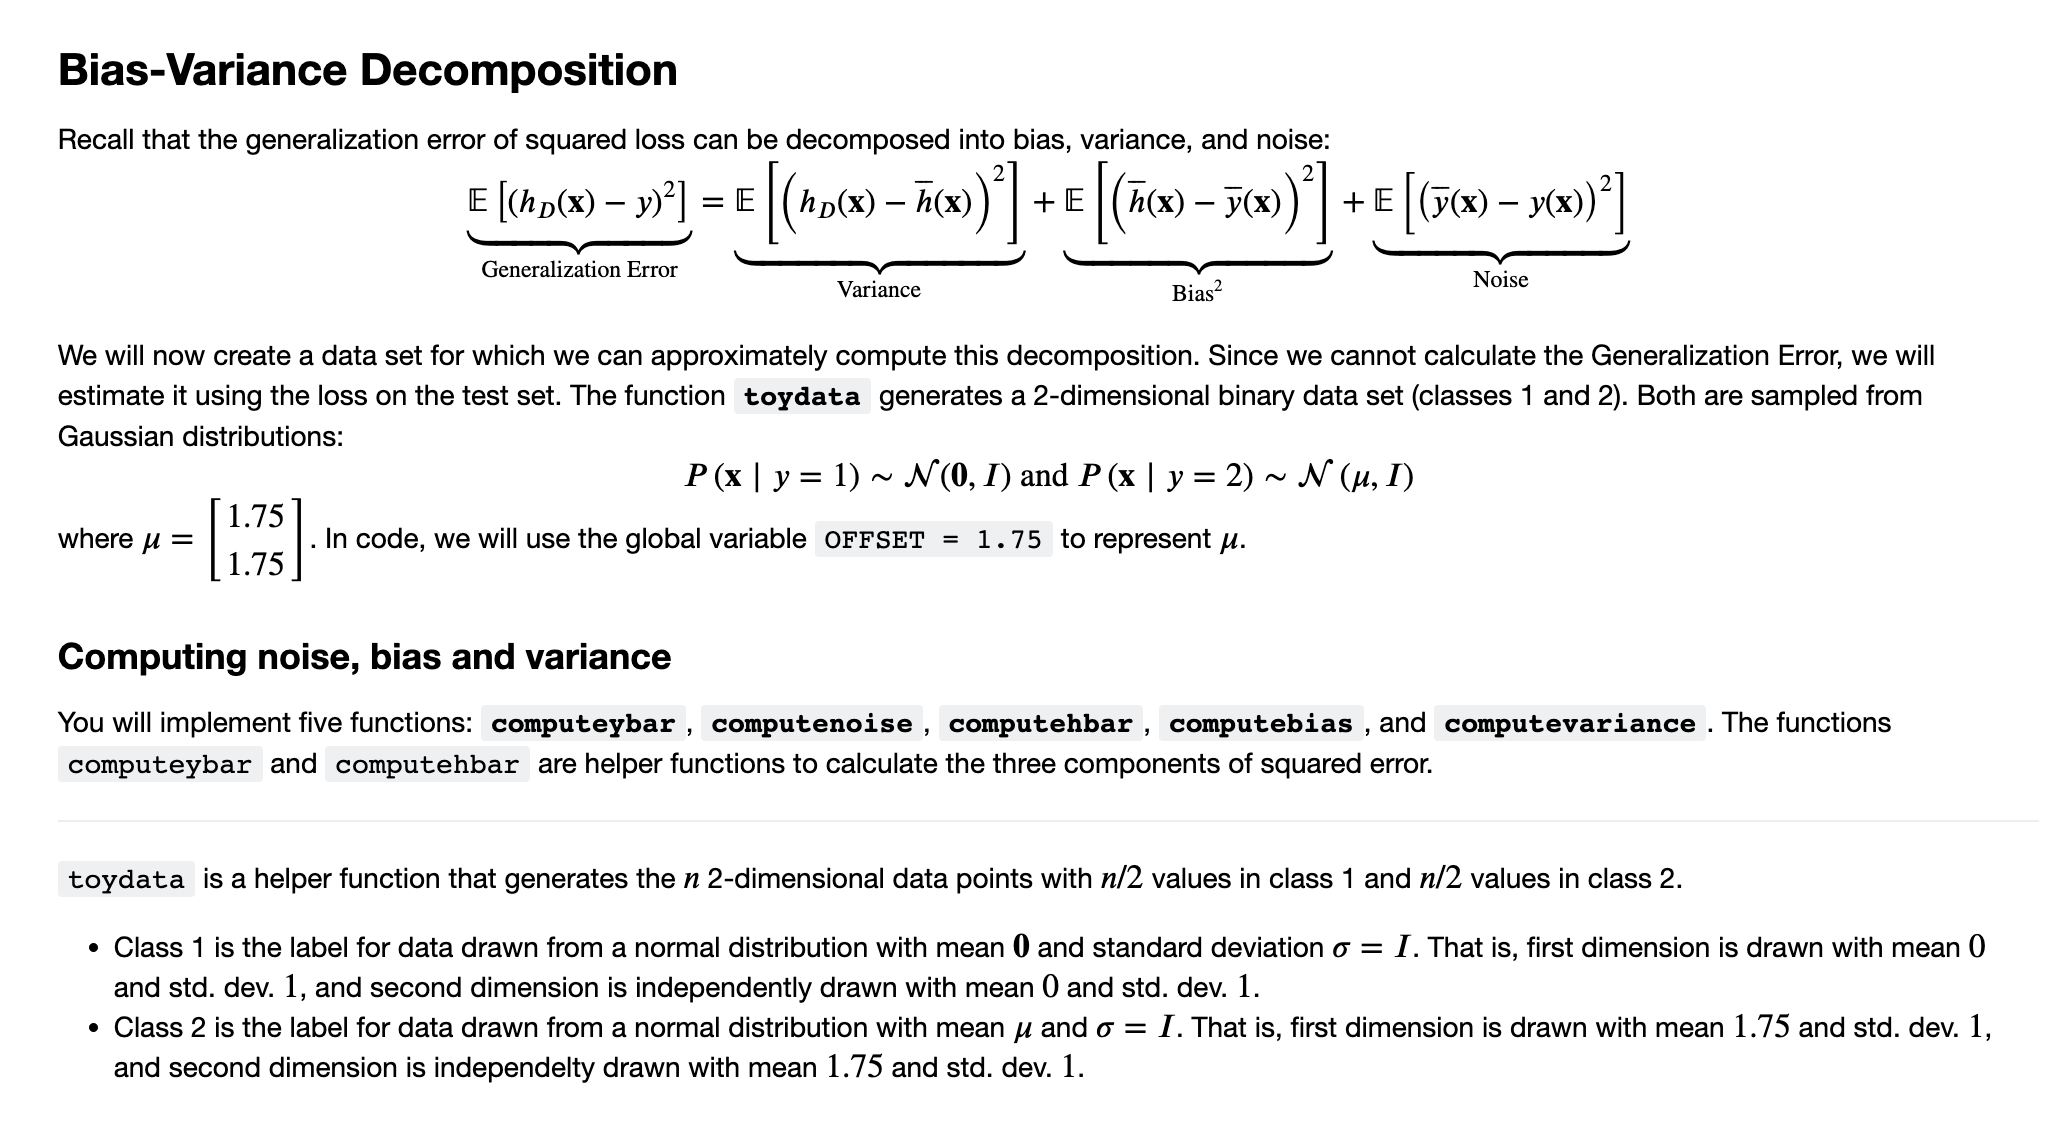

In [ ]:
def toydata(OFFSET, num_samples):
    # Generate class 1 samples from Gaussian distribution N(0, 1)
    class1_samples = np.random.normal(loc=0, scale=1, size=(num_samples, 2))

    # Generate class 2 samples from Gaussian distribution N(M, 1)
    class2_samples = np.random.normal(loc=OFFSET, scale=1, size=(num_samples, 2))

    # Create labels for the classes
    class1_labels = np.ones(num_samples)
    class2_labels = np.ones(num_samples) * 2

    # Combine the samples and labels for both classes
    X = np.vstack((class1_samples, class2_samples))
    y = np.concatenate((class1_labels, class2_labels))

    # Shuffle the samples and labels randomly
    indices = np.random.permutation(num_samples * 2)
    X = X[indices]
    y = y[indices]

    return X, y

In [ ]:
num_samples = 100  # Number of samples for each class
data, labels = toydata(num_samples)

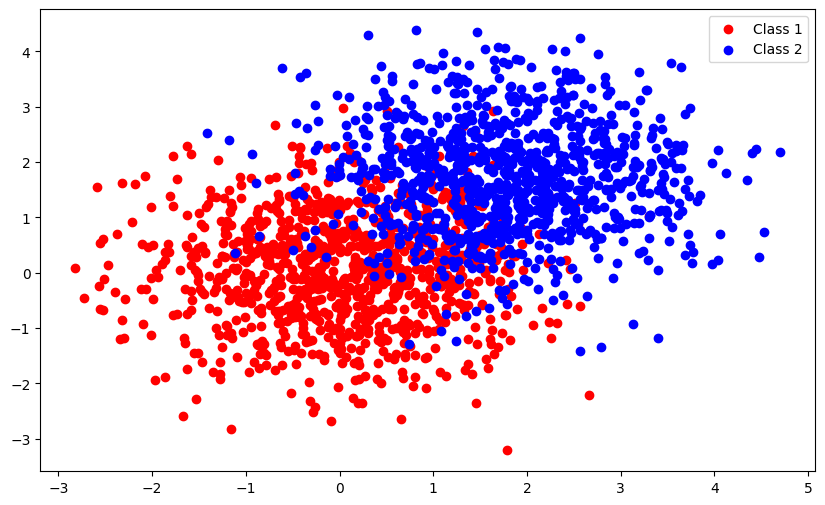

In [ ]:
OFFSET = 1.75 # mu = [OFFSET, OFFSET]
X, y = toydata(OFFSET, 1000)

# Visualize the generated data
ind1 = y == 1
ind2 = y == 2
plt.figure(figsize=(10, 6))
plt.scatter(X[ind1, 0], X[ind1, 1], c='r', marker='o', label='Class 1')
plt.scatter(X[ind2, 0], X[ind2, 1], c='b', marker='o', label='Class 2')
plt.legend();

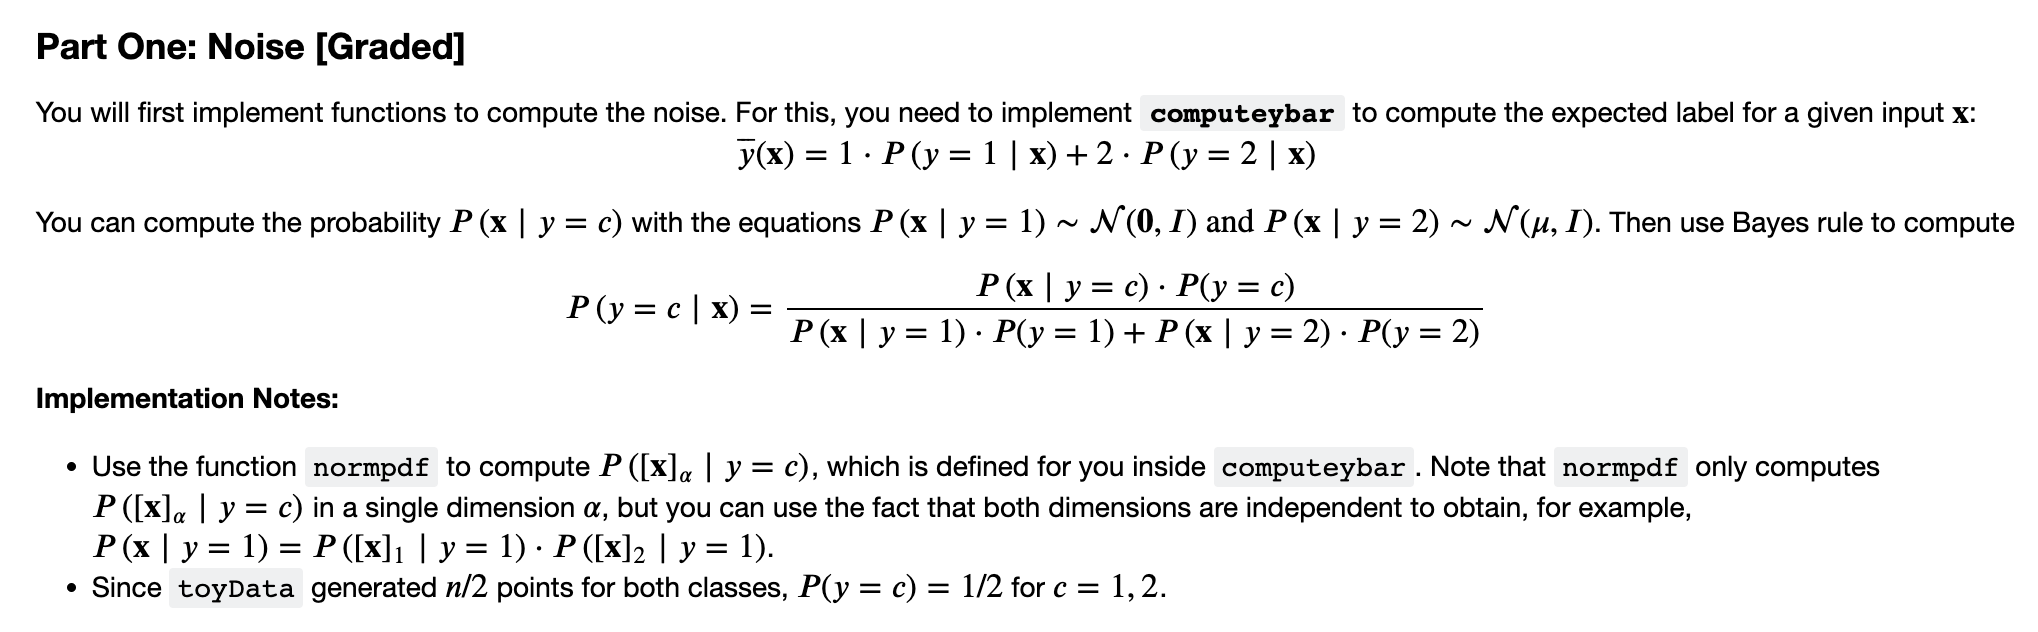

In [ ]:
def computeybar(xTe, OFFSET):
    """
    Computes the expected label 'ybar' for a set of inputs xTe,
    generated from two Normal distributions (the first with mean 0 and std. dev. I
    and the second with mean [OFFSET, OFFSET] and std. dev. I).

    Input:
        xTe    : data matrix of shape nx2 # each data point has 2 dimensions x1 and x2
        OFFSET : The OFFSET passed into the toyData function. The difference in the
                 mu of normal distributions for points with labels class1 and class2.

    Output:
        ybar   : a nx1 vector of the expected labels for each vector in xTe
    """
    n, d = xTe.shape
    ybar = np.zeros(n)

    # Feel free to use the following function to compute P( [x]_\alpha | y )
    normpdf = lambda x, mu, sigma: np.exp(-0.5 * np.power((x - mu) / sigma, 2)) / (np.sqrt(2 * np.pi) * sigma)

    for i in range(n):
      nominator = normpdf(xTe[i, 0],0,1)*normpdf(xTe[i,1],0, 1) + 2*normpdf(xTe[i,0], OFFSET,1)*normpdf(xTe[i,1], OFFSET,1)
      denominator = normpdf(xTe[i, 0],0,1)*normpdf(xTe[i,1],0, 1) + normpdf(xTe[i,0], OFFSET,1)*normpdf(xTe[i,1], OFFSET,1)
      c = nominator / denominator
      ybar[i]=c

    return ybar

In [ ]:
#alternative formulation
def computeybar(xTe, OFFSET):
    """
    Computes the expected label 'ybar' for a set of inputs xTe,
    generated from two Normal distributions (the first with mean 0 and std. dev. I
    and the second with mean [OFFSET, OFFSET] and std. dev. I).

    Input:
        xTe    : data matrix of shape nx2 # each data point has 2 dimensions x1 and x2
        OFFSET : The OFFSET passed into the toyData function. The difference in the
                 mu of normal distributions for points with labels class1 and class2.

    Output:
        ybar   : a nx1 vector of the expected labels for each vector in xTe
    """
    n, d = xTe.shape
    ybar = np.zeros(n)

    # Feel free to use the following function to compute P( [x]_alpha | y )
    normpdf = lambda x, mu, sigma: np.exp(-0.5 * np.power((x - mu) / sigma, 2)) / (np.sqrt(2 * np.pi) * sigma)

    for i in range(n):
        p_x_given_1 = normpdf(xTe[i, 0], 0, 1) * normpdf(xTe[i, 1], 0, 1)
        p_x_given_2 = normpdf(xTe[i, 0], OFFSET, 1) * normpdf(xTe[i, 1], OFFSET, 1)
        p_y_given_x_1 = p_x_given_1 * 0.5 / (p_x_given_1 + p_x_given_2)
        p_y_given_x_2 = p_x_given_2 * 0.5 / (p_x_given_1 + p_x_given_2)
        ybar[i] = p_y_given_x_1 + 2 * p_y_given_x_2

    return ybar


In [ ]:
def test_ybar1():
    OFFSET = 2
    n = 1000
    xTe, yTe = toydata(OFFSET, n) # Generate n datapoints
    ybar = computeybar(xTe, OFFSET)

    return ybar.shape == (n, ) # the output of your ybar should be a n dimensional array

def test_ybar2():
    OFFSET = 50
    # Create an easy dataset
    # We set sigma=1 and since the mean is far apart,
    # the noise is negligible
    xTe = np.array([
        [49.308783, 49.620651],
        [1.705462, 1.885418],
        [ 51.192402, 50.256330],
        [0.205998, -0.089885],
        [50.853083, 51.833237]])
    yTe = np.array([2, 1, 2, 1, 2])

    ybar = computeybar(xTe, OFFSET)
    return np.isclose(np.mean(np.power(yTe - ybar, 2)), 0)

def test_ybar3():
    OFFSET = 3;

    xTe = np.array([
        [0.45864, 0.71552],
        [2.44662, 1.68167],
        [1.00345, 0.15182],
        [-0.10560, -0.48155],
        [3.07264, 3.81535],
        [3.13035, 2.72151],
        [2.25265, 3.78697]])
    yTe = np.array([1, 2, 1, 1, 2, 2, 2])

    ybar = computeybar(xTe, OFFSET)

    return np.mean(np.power(yTe - ybar, 2)) < 0.0002 # make sure the noise is small

runtest(test_ybar1, 'test_ybar1')
runtest(test_ybar2, 'test_ybar2')
runtest(test_ybar3, 'test_ybar3')

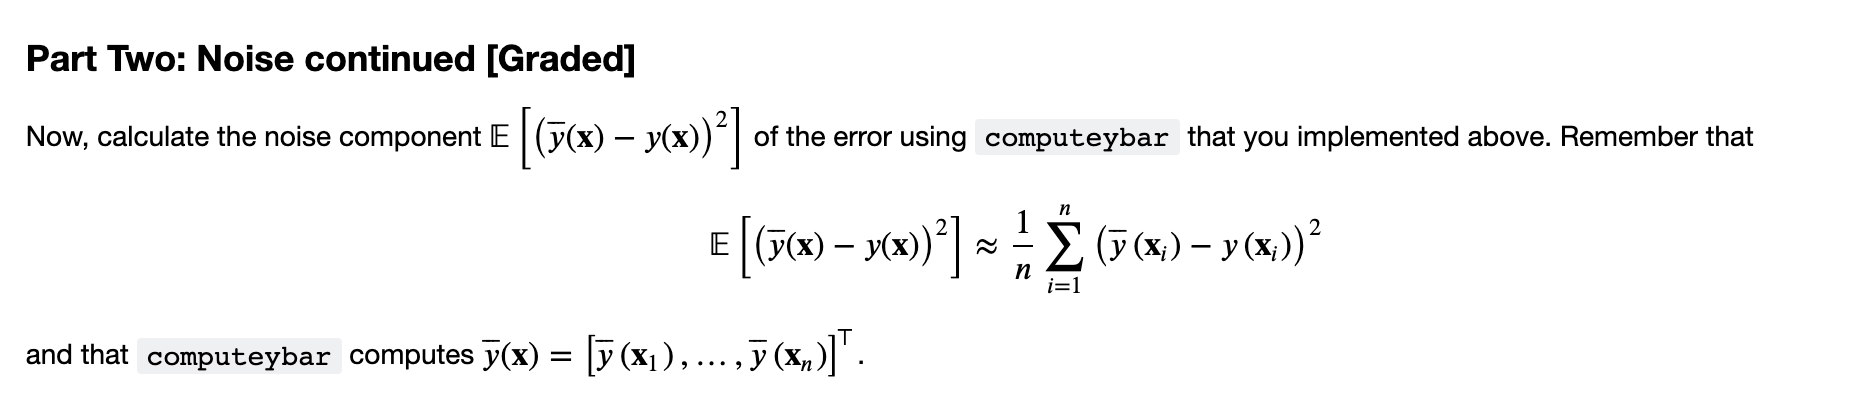

In [ ]:
def computenoise(xTe, yTe, OFFSET):
    """
    Computes the noise, or square mean of ybar - y, for a set of inputs (xTe, yTe) generated with toyData
    using OFFSET.

    Input:
        xTe       : data matrix of shape nx2
        yTe       : n-dimensional array of true labels
        OFFSET    : The OFFSET passed into the toyData function. The difference in the
                    mu of normal distributions for points with labels class1 and class2.

    Output:
        noise:    : a scalar representing the noise component of the error of xTe
    """
    noise = 0
    n, d = xTe.shape

    ybar = computeybar(xTe, OFFSET)

    noise = 1/n * np.sum((np.subtract(ybar, yTe))**2)

    return noise

In [ ]:
#alternative implementation
def computenoise(xTe, yTe, OFFSET):
    """
    Computes the noise, or square mean of ybar - y, for a set of inputs (xTe, yTe) generated with toyData
    using OFFSET.

    Input:
        xTe       : data matrix of shape nx2
        yTe       : n-dimensional array of true labels
        OFFSET    : The OFFSET passed into the toyData function. The difference in the
                    mu of normal distributions for points with labels class1 and class2.

    Output:
        noise     : a scalar representing the noise component of the error of xTe
    """
    n, d = xTe.shape

    ybar = computeybar(xTe, OFFSET)
    noise = np.mean(np.square(ybar - yTe))

    return noise

In [ ]:
def test_noise1():
    OFFSET = 2
    n = 1000
    xTe, yTe = toydata(OFFSET, n) # Generate n datapoints
    noise = computenoise(xTe, yTe, OFFSET)

    return np.isscalar(noise)

def test_noise2():
    OFFSET = 50
    # Create an easy dataset
    # We set sigma=1 and since the mean is far apart,
    # the noise is negligible
    xTe = np.array([
        [49.308783, 49.620651],
        [1.705462, 1.885418],
        [ 51.192402, 50.256330],
        [0.205998, -0.089885],
        [50.853083, 51.833237]])
    yTe = np.array([2, 1, 2, 1, 2])
    noise = computenoise(xTe, yTe, OFFSET)
    return np.isclose(noise,0)

def test_noise3():
    OFFSET = 3;

    xTe = np.array([
        [0.45864, 0.71552],
        [2.44662, 1.68167],
        [1.00345, 0.15182],
        [-0.10560, -0.48155],
        [3.07264, 3.81535],
        [3.13035, 2.72151],
        [2.25265, 3.78697]])
    yTe = np.array([1, 2, 1, 1, 2, 2, 2])

    ybar = computeybar(xTe, OFFSET)
    noise = computenoise(xTe,yTe,OFFSET)

    return noise < 0.0002 # make sure the noise is small

runtest(test_noise1, 'test_noise1')
runtest(test_noise2, 'test_noise2')
runtest(test_noise3, 'test_noise3')

Error of Bayes classifier: 11.35%.
Noise: 0.0788


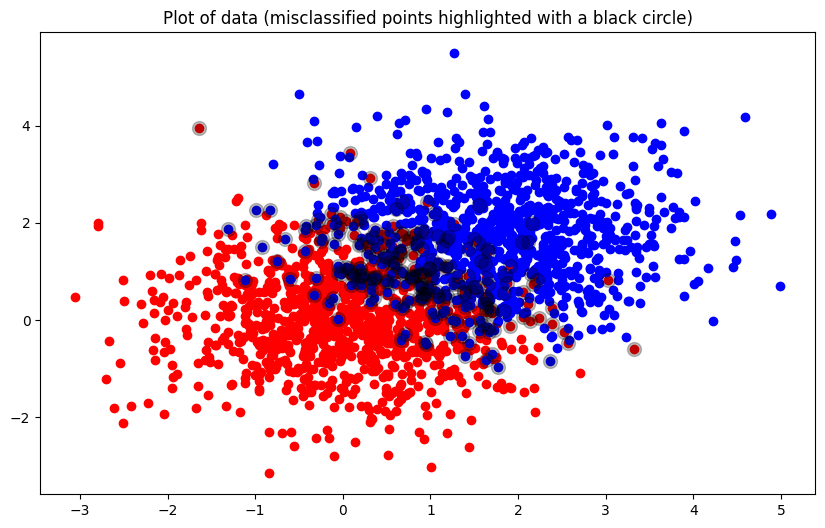

In [ ]:
OFFSET = 1.75
np.random.seed(1)
xTe, yTe = toydata(OFFSET, 1000)

# compute Bayes Error
ybar = computeybar(xTe, OFFSET)
predictions = np.round(ybar)
errors = predictions != yTe
err = errors.sum() / len(yTe) * 100
print('Error of Bayes classifier: %.2f%%.' % err)

# print out the noise
print('Noise: %.4f' % computenoise(xTe, yTe, OFFSET))

# plot data
ind1 = yTe == 1
ind2 = yTe == 2
plt.figure(figsize=(10,6))
plt.scatter(xTe[ind1, 0], xTe[ind1, 1], c='r', marker='o')
plt.scatter(xTe[ind2, 0], xTe[ind2, 1], c='b', marker='o')
plt.scatter(xTe[errors, 0], xTe[errors, 1], c='k', s=100, alpha=0.25)
plt.title("Plot of data (misclassified points highlighted with a black circle)")
plt.show()

As you can see from the graph above, the dataset is noisy and cannot be classified into two groups cleanly, thus giving non-zero noise and non-zero bayes error!

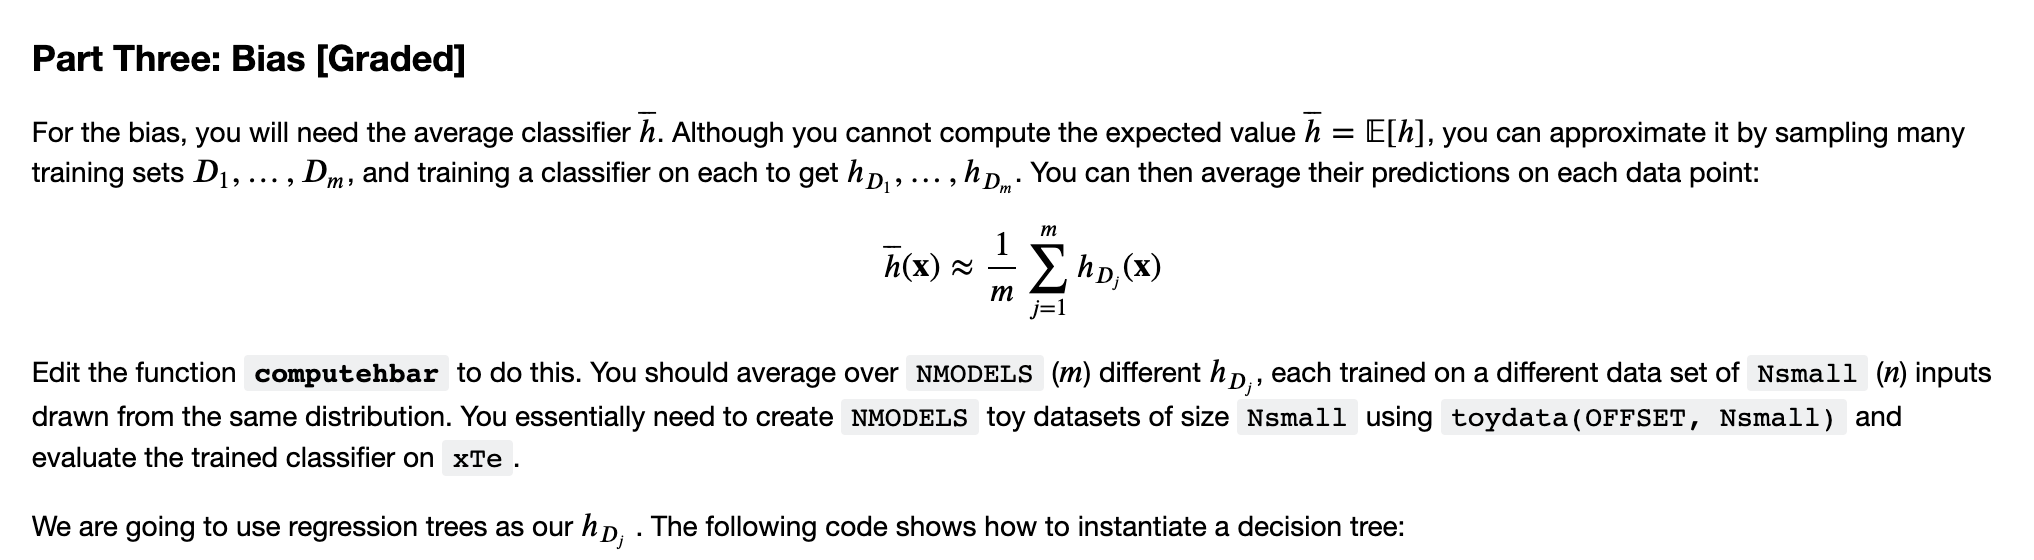

In [ ]:
#RegressionTree function

class RegressionTree:
    def __init__(self, depth=np.inf):
        self.depth = depth
        self.tree = None

    def fit(self, xTr, yTr):
        self.tree = self._build_tree(xTr, yTr, depth=0)

    def predict(self, xTe):
        if self.tree is None:
            raise RuntimeError("The tree has not been trained. Please call the fit() method first.")

        return np.array([self._predict_one_sample(x, self.tree) for x in xTe])

    def _build_tree(self, xTr, yTr, depth):
        if depth >= self.depth or len(np.unique(yTr)) == 1:
            return np.mean(yTr)

        feature_index, threshold = self._find_best_split(xTr, yTr)

        if feature_index is None or threshold is None:
            return np.mean(yTr)

        left_indices = xTr[:, feature_index] < threshold
        right_indices = xTr[:, feature_index] >= threshold

        left_tree = self._build_tree(xTr[left_indices], yTr[left_indices], depth + 1)
        right_tree = self._build_tree(xTr[right_indices], yTr[right_indices], depth + 1)

        return {'feature_index': feature_index, 'threshold': threshold,
                'left_tree': left_tree, 'right_tree': right_tree}

    def _find_best_split(self, xTr, yTr):
        best_mse = np.inf
        best_feature_index = None
        best_threshold = None

        for feature_index in range(xTr.shape[1]):
            thresholds = np.unique(xTr[:, feature_index])

            for threshold in thresholds:
                left_indices = xTr[:, feature_index] < threshold
                right_indices = xTr[:, feature_index] >= threshold

                if np.sum(left_indices) > 0 and np.sum(right_indices) > 0:
                    left_predictions = np.mean(yTr[left_indices])
                    right_predictions = np.mean(yTr[right_indices])

                    mse = np.mean((yTr[left_indices] - left_predictions) ** 2) + np.mean((yTr[right_indices] - right_predictions) ** 2)

                    if mse < best_mse:
                        best_mse = mse
                        best_feature_index = feature_index
                        best_threshold = threshold

        return best_feature_index, best_threshold

    def _predict_one_sample(self, x, tree):
        if isinstance(tree, dict):
            if x[tree['feature_index']] < tree['threshold']:
                return self._predict_one_sample(x, tree['left_tree'])
            else:
                return self._predict_one_sample(x, tree['right_tree'])
        else:
            return tree


In [ ]:
xTr, yTr = toydata(OFFSET, 100)

# Create a regression tree with no restriction on its depth
# if you want to create a tree of depth k
# then call RegressionTree(depth=k)
tree = RegressionTree(depth=np.inf)

# To fit/train the regression tree
tree.fit(xTr, yTr)

# To use the trained regression tree to make prediction
pred = tree.predict(xTr)

In [ ]:
def computehbar(xTe, depth, Nsmall, NMODELS, OFFSET):
    """
    Computes the prediction of the average regression tree (hbar) on dataset xTe.
    Each of the NMODELS regression trees used in the average tree should be
    trained using data from toydata(OFFSET, Nsmall).

    Input:
        xTe       : data matrix of shape nx2
        depth     : Depth of each regression tree to be trained
        Nsmall    : Number of points in the dataset that each tree is trained on
        NMODELS   : Number of regression trees to train
        OFFSET    : The OFFSET passed into the toyData function. The difference in the
                    mu of normal distributions for points with labels class1 and class2.
    Output:
        hbar      : a nx1 vector of the expected labels for each vector in xTe
    """
    n = xTe.shape[0]
    hbar = np.zeros(n)
    pred = np.zeros((n, NMODELS))

    for i in range(NMODELS):
        xTr, yTr = toydata(OFFSET, Nsmall)
        tree = RegressionTree(depth=depth)
        tree.fit(xTr, yTr)
        pred[:, i] = tree.predict(xTe)

    hbar = np.mean(pred, axis=1)

    return hbar

In [ ]:
def test_hbar1():
    OFFSET = 2
    depth = 2
    Nsmall = 10
    NMODELS = 10
    n = 1000
    xTe, yTe = toydata(OFFSET, n)
    hbar = computehbar(xTe, depth, Nsmall, NMODELS, OFFSET)
    return hbar.shape == (n, ) # the dimension of hbar should be (n, )

def test_hbar2():
    OFFSET = 50
    # Create an easy dataset
    # We set sigma=1 and since the mean is far apart,
    # the noise is negligible
    xTe = np.array([
        [49.308783, 49.620651],
        [1.705462, 1.885418],
        [51.192402, 50.256330],
        [0.205998, -0.089885],
        [50.853083, 51.833237]])
    yTe = np.array([2, 1, 2, 1, 2])

    depth = 2
    Nsmall = 10
    NMODELS = 1

    # since the mean is far apart, the tree should be able to learn perfectly
    hbar = computehbar(xTe, depth, Nsmall, NMODELS, OFFSET)
    ybar = computeybar_grader(xTe, OFFSET)
    bias = np.mean(np.power(hbar-ybar,2))
    return np.isclose(bias, 0) # the bias should be close to zero

def test_hbar3():
    OFFSET = 3;

    xTe = np.array([
        [0.45864, 0.71552],
        [2.44662, 1.68167],
        [1.00345, 0.15182],
        [-0.10560, -0.48155],
        [3.07264, 3.81535],
        [3.13035, 2.72151],
        [2.25265, 3.78697]])
    yTe = np.array([1, 2, 1, 1, 2, 2, 2])

    depth = 3
    Nsmall = 10
    NMODELS = 100

    # set the random seed to ensure consistent behavior
    np.random.seed(1)
    hbar = computehbar(xTe, depth, Nsmall, NMODELS, OFFSET)
    ybar = computeybar_grader(xTe, OFFSET)
    bias = np.mean(np.power(hbar-ybar, 2))
    return np.abs(bias - 0.0017) < 0.001 # the bias should be close to 0.007

runtest(test_hbar1, 'test_hbar1')
runtest(test_hbar2, 'test_hbar2')
runtest(test_hbar3, 'test_hbar3')

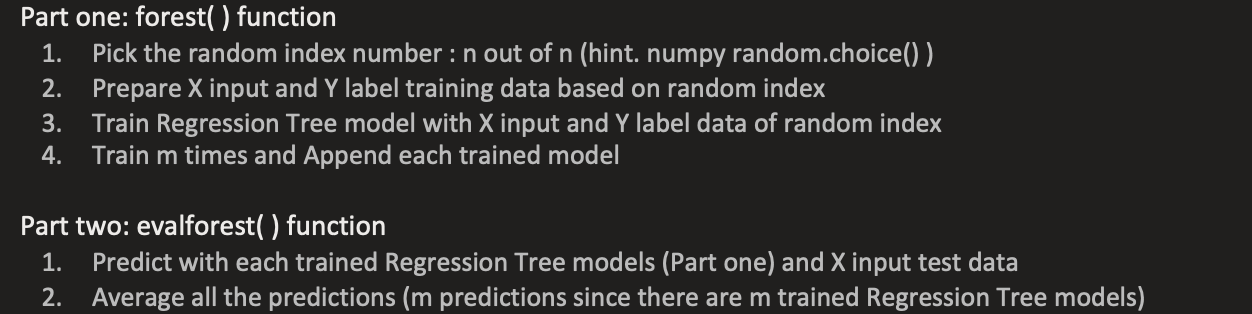

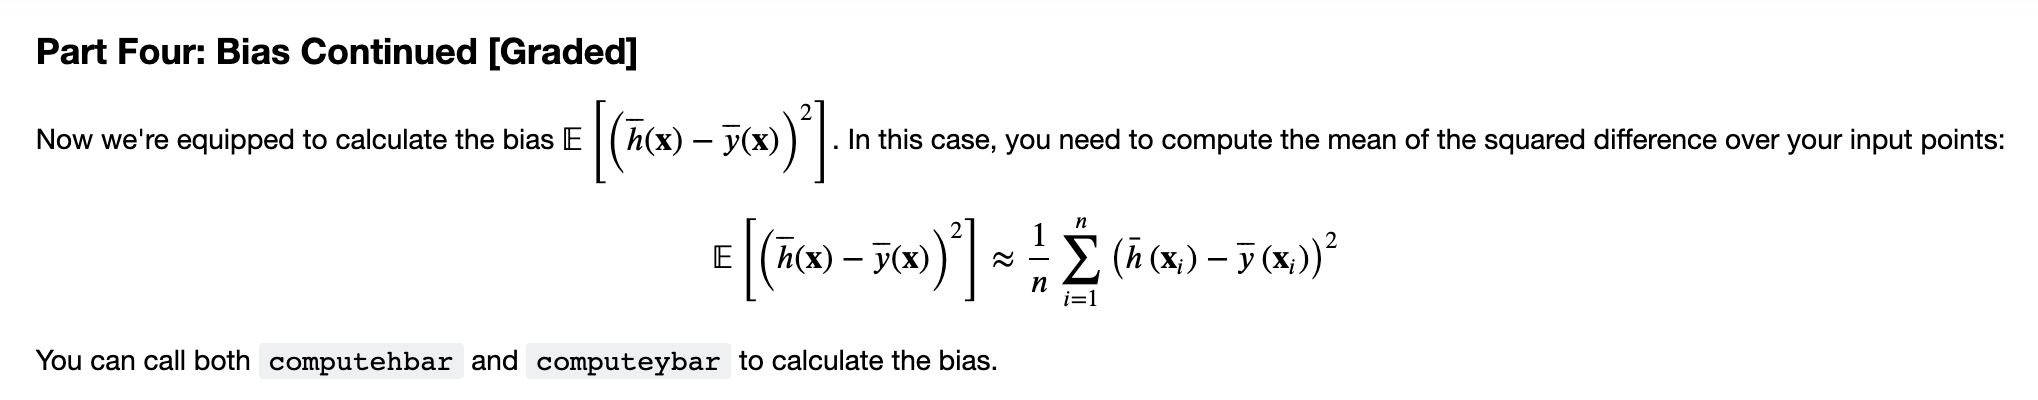

In [ ]:
def computebias(xTe, depth, Nsmall, NMODELS, OFFSET):
    """
    Computes the bias for data set xTe.
    Each of the NMODELS regression trees used in the average tree should be
    trained using data from toydata(OFFSET, Nsmall).

    Input:
        xTe       : data matrix of shape nx2
        depth     : Depth of each regression tree to be trained
        Nsmall    : Number of points in the dataset that each tree is trained on
        NMODELS   : Number of regression trees to train
        OFFSET    : The OFFSET passed into the toyData function. The difference in the
                    mu of normal distributions for points with labels class1 and class2.

    Output:
        bias      : a scalar representing the bias component of the error of xTe
    """
    bias = 0

    hbar = computehbar(xTe, depth, Nsmall, NMODELS, OFFSET)
    ybar = computeybar(xTe, OFFSET)

    bias = np.mean((np.subtract(ybar, hbar))**2)
    return bias

In [ ]:
def test_bias1():
    OFFSET = 2
    depth = 2
    Nsmall = 10
    NMODELS = 10
    n = 1000
    xTe, yTe = toydata(OFFSET, n)
    bias = computebias(xTe, depth, Nsmall, NMODELS, OFFSET)
    return np.isscalar(bias) # the dimension of hbar should be (n, )

def test_bias2():
    OFFSET = 50
    # Create an easy dataset
    # We set sigma=1 and since the mean is far apart,
    # the noise is negligible
    xTe = np.array([
        [49.308783, 49.620651],
        [1.705462, 1.885418],
        [51.192402, 50.256330],
        [0.205998, -0.089885],
        [50.853083, 51.833237]])
    yTe = np.array([2, 1, 2, 1, 2])

    depth = 2
    Nsmall = 10
    NMODELS = 1

    # since the mean is far apart, the tree should be able to learn perfectly
    bias = computebias(xTe, depth, Nsmall, NMODELS, OFFSET)
    return np.isclose(bias, 0) # the bias should be close to zero

def test_bias3():
    OFFSET = 3;

    xTe = np.array([
        [0.45864, 0.71552],
        [2.44662, 1.68167],
        [1.00345, 0.15182],
        [-0.10560, -0.48155],
        [3.07264, 3.81535],
        [3.13035, 2.72151],
        [2.25265, 3.78697]])
    yTe = np.array([1, 2, 1, 1, 2, 2, 2])

    depth = 3
    Nsmall = 10
    NMODELS = 100

    # set the random seed to ensure consistent behavior
    bias = computebias(xTe, depth, Nsmall, NMODELS, OFFSET)
    return np.abs(bias - 0.0017) < 0.001 # the bias should be close to 0.007

runtest(test_bias1, 'test_bias1')
runtest(test_bias2, 'test_bias2')
runtest(test_bias3, 'test_bias3')

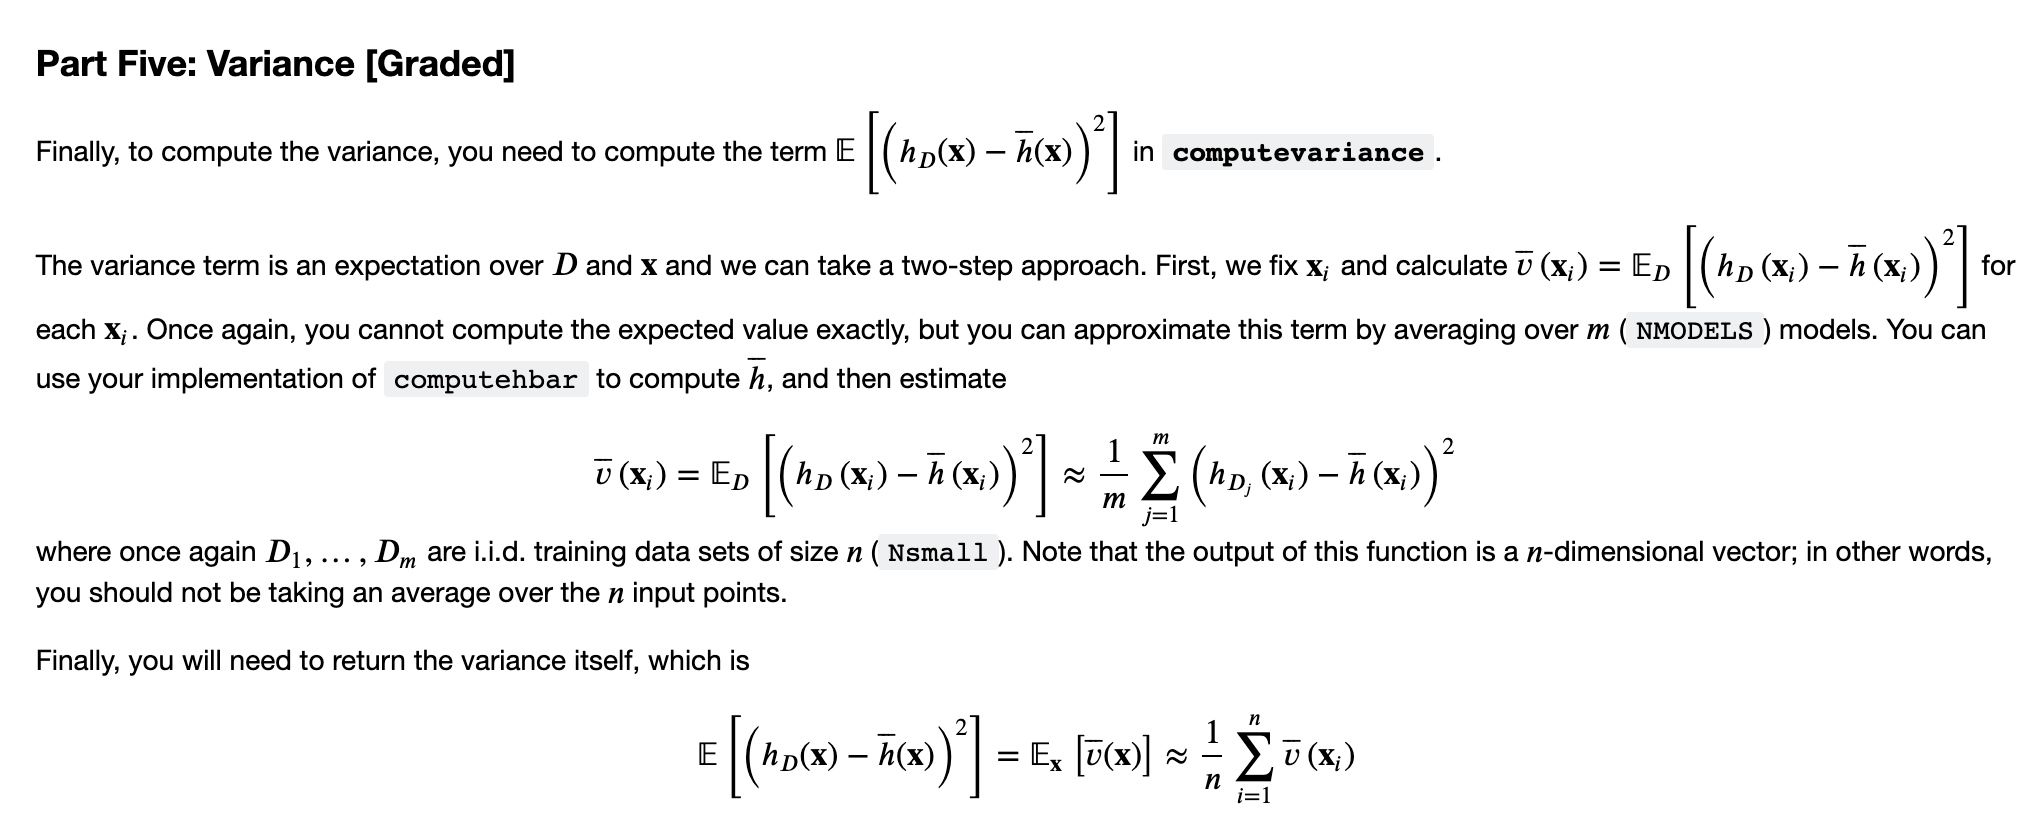

In [ ]:
def computevariance(xTe, depth, hbar, Nsmall, NMODELS, OFFSET):
    """
    Computes the variance of classifiers trained on data sets from toydata(OFFSET, Nsmall).
    The prediction of the average classifier is assumed to be stored in "hbar".

    Input:
        xTe       : data matrix of shape nx2
        depth     : Depth of each regression tree to be trained
        hbar      : nx1 vector of the predictions of hbar on the inputs xTe
        Nsmall    : Number of points in the dataset that each tree is trained on
        NMODELS   : Number of regression trees to train
        OFFSET    : The OFFSET passed into the toyData function. The difference in the
                    mu of normal distributions for points with labels class1 and class2.

    Output:
        variance  : a scalar representing the bias component of the error of xTe
    """
    n = xTe.shape[0]
    vbar = np.zeros(n)
    variance = 0
    hbar = computehbar(xTe, depth, Nsmall, NMODELS, OFFSET)
    pred = np.zeros((n, NMODELS))

    for i in range(NMODELS):
        xTr, yTr = toydata(OFFSET, Nsmall)
        tree = RegressionTree(depth=depth)
        tree.fit(xTr, yTr)
        pred[:, i] = tree.predict(xTe)
        for l in range(n):
          vbar[l] = (np.subtract(hbar[l, None], pred[l,i]))**2

    variance = np.mean(vbar)

    return variance

In [ ]:
#correct implementation
def computevariance(xTe, depth, hbar, Nsmall, NMODELS, OFFSET):
    """
    Computes the variance of classifiers trained on data sets from toydata(OFFSET, Nsmall).
    The prediction of the average classifier is assumed to be stored in "hbar".

    Input:
        xTe       : data matrix of shape nx2
        depth     : Depth of each regression tree to be trained
        hbar      : nx1 vector of the predictions of hbar on the inputs xTe
        Nsmall    : Number of points in the dataset that each tree is trained on
        NMODELS   : Number of regression trees to train
        OFFSET    : The OFFSET passed into the toyData function. The difference in the
                    mu of normal distributions for points with labels class1 and class2.

    Output:
        variance  : a scalar representing the bias component of the error of xTe
    """
    n = xTe.shape[0]
    vbar = np.zeros(n)
    variance = 0
    pred = np.zeros((n, NMODELS))

    for i in range(NMODELS):
        xTr, yTr = toydata(OFFSET, Nsmall)
        tree = RegressionTree(depth=depth)
        tree.fit(xTr, yTr)
        pred[:, i] = tree.predict(xTe)

    variance = np.mean((pred - hbar[:, None]) ** 2)

    return variance

In [ ]:
def test_variance1():
    OFFSET = 2
    depth = 2
    Nsmall = 10
    NMODELS = 10
    n = 1000
    xTe, yTe = toydata(OFFSET, n)
    hbar = computehbar_grader(xTe, depth, Nsmall, NMODELS, OFFSET)
    var = computevariance(xTe, depth, hbar, Nsmall, NMODELS, OFFSET)
    return np.isscalar(var) # variance should be a scalar

def test_variance2():
    OFFSET = 50
    # Create an easy dataset
    # We set sigma=1 and since the mean is far apart,
    # the noise is negligible
    xTe = np.array([
        [49.308783, 49.620651],
        [1.705462, 1.885418],
        [51.192402, 50.256330],
        [0.205998, -0.089885],
        [50.853083, 51.833237]])
    yTe = np.array([2, 1, 2, 1, 2])

    depth = 2
    Nsmall = 10
    NMODELS = 10

    # since the noise is negligible, the tree should be able to learn perfectly
    hbar = computehbar_grader(xTe, depth, Nsmall, NMODELS, OFFSET)
    var = computevariance(xTe, depth, hbar, Nsmall, NMODELS, OFFSET)
    return np.isclose(var, 0) # the bias should be close to zero

def test_variance3():
    OFFSET = 3;

    xTe = np.array([
        [0.45864, 0.71552],
        [2.44662, 1.68167],
        [1.00345, 0.15182],
        [-0.10560, -0.48155],
        [3.07264, 3.81535],
        [3.13035, 2.72151],
        [2.25265, 3.78697]])
    yTe = np.array([1, 2, 1, 1, 2, 2, 2])

    depth = 3
    Nsmall = 10
    NMODELS = 100

    # set the random seed to ensure consistent behavior
    np.random.seed(1)
    # since the noise is negligible, the tree should be able to learn perfectly
    hbar = computehbar_grader(xTe, depth, Nsmall, NMODELS, OFFSET)
    var = computevariance(xTe, depth, hbar, Nsmall, NMODELS, OFFSET)
    return np.abs(var - 0.0404) < 0.0015 # the variance should be close to 0.0404

runtest(test_variance1, 'test_variance1')
runtest(test_variance2, 'test_variance2')
runtest(test_variance3, 'test_variance3')

In [ ]:
# biasvariancedemo

OFFSET = 1.75
# how big is the training set size N
Nsmall = 75
# how big is a really big data set (approx. infinity)
Nbig = 7500
# how many models do you want to average over
NMODELS = 100
# What regularization constants to evaluate
depths = [0, 1, 2, 3, 4, 5, 6, np.inf]

# we store
Ndepths = len(depths)
lbias = np.zeros(Ndepths)
lvariance = np.zeros(Ndepths)
ltotal = np.zeros(Ndepths)
lnoise = np.zeros(Ndepths)
lsum = np.zeros(Ndepths)

# Different regularization constant classifiers
for i in range(Ndepths):
    depth = depths[i]
    # use this data set as an approximation of the true test set
    xTe,yTe = toydata(OFFSET, Nbig)

    # Estimate AVERAGE ERROR (TOTAL)
    total = 0
    for j in range(NMODELS):
        # Set the seed for consistent behavior
        xTr2,yTr2 = toydata(OFFSET, Nsmall)
        model = RegressionTree(depth=depth)
        model.fit(xTr2, yTr2)
        total += np.mean((model.predict(xTe) - yTe) ** 2)
    total /= NMODELS

    # Estimate Noise
    noise = computenoise(xTe, yTe, OFFSET)

    # Estimate Bias
    bias = computebias(xTe,depth,Nsmall, NMODELS, OFFSET)

    # Estimating VARIANCE
    hbar = computehbar(xTe, depth, Nsmall, NMODELS, OFFSET)
    variance = computevariance(xTe, depth, hbar, Nsmall, NMODELS, OFFSET)

    # print and store results
    lbias[i] = bias
    lvariance[i] = variance
    ltotal[i] = total
    lnoise[i] = noise
    lsum[i] = lbias[i]+lvariance[i]+lnoise[i]

    if np.isinf(depths[i]):
        print('Depth infinite: Bias: %2.4f Variance: %2.4f Noise: %2.4f Bias+Variance+Noise: %2.4f Test error: %2.4f'
          % (lbias[i],lvariance[i],lnoise[i],lsum[i],ltotal[i]))
    else:
        print('Depth: %d: Bias: %2.4f Variance: %2.4f Noise: %2.4f Bias+Variance+Noise: %2.4f Test error: %2.4f'
          % (depths[i],lbias[i],lvariance[i],lnoise[i],lsum[i],ltotal[i]))


Depth: 0: Bias: 0.1716 Variance: 0.0000 Noise: 0.0769 Bias+Variance+Noise: 0.2485 Test error: 0.2500
Depth: 1: Bias: 0.0540 Variance: 0.0651 Noise: 0.0769 Bias+Variance+Noise: 0.1960 Test error: 0.1858
Depth: 2: Bias: 0.0280 Variance: 0.0541 Noise: 0.0754 Bias+Variance+Noise: 0.1574 Test error: 0.1596
Depth: 3: Bias: 0.0289 Variance: 0.0604 Noise: 0.0799 Bias+Variance+Noise: 0.1692 Test error: 0.1629
Depth: 4: Bias: 0.0269 Variance: 0.0871 Noise: 0.0780 Bias+Variance+Noise: 0.1920 Test error: 0.1587
Depth: 5: Bias: 0.0211 Variance: 0.0583 Noise: 0.0783 Bias+Variance+Noise: 0.1577 Test error: 0.1599
Depth: 6: Bias: 0.0256 Variance: 0.0668 Noise: 0.0773 Bias+Variance+Noise: 0.1697 Test error: 0.1576
Depth infinite: Bias: 0.0054 Variance: 0.1125 Noise: 0.0764 Bias+Variance+Noise: 0.1943 Test error: 0.1931


Depth: 0: Bias: 0.1716 Variance: 0.0000 Noise: 0.0764 Bias+Variance+Noise: 0.2480 Test error: 0.2500

Depth: 1: Bias: 0.0303 Variance: 0.0552 Noise: 0.0792 Bias+Variance+Noise: 0.1648 Test error: 0.1640

Depth: 2: Bias: 0.0053 Variance: 0.0407 Noise: 0.0771 Bias+Variance+Noise: 0.1232 Test error: 0.1236

Depth: 3: Bias: 0.0037 Variance: 0.0469 Noise: 0.0770 Bias+Variance+Noise: 0.1276 Test error: 0.1300

Depth: 4: Bias: 0.0025 Variance: 0.0706 Noise: 0.0820 Bias+Variance+Noise: 0.1550 Test error: 0.1511

Depth: 5: Bias: 0.0021 Variance: 0.0778 Noise: 0.0768 Bias+Variance+Noise: 0.1567 Test error: 0.1563

Depth: 6: Bias: 0.0026 Variance: 0.0848 Noise: 0.0783 Bias+Variance+Noise: 0.1657 Test error: 0.1697

Depth infinite: Bias: 0.0028 Variance: 0.0882 Noise: 0.0782 Bias+Variance+Noise: 0.1692 Test error: 0.1734

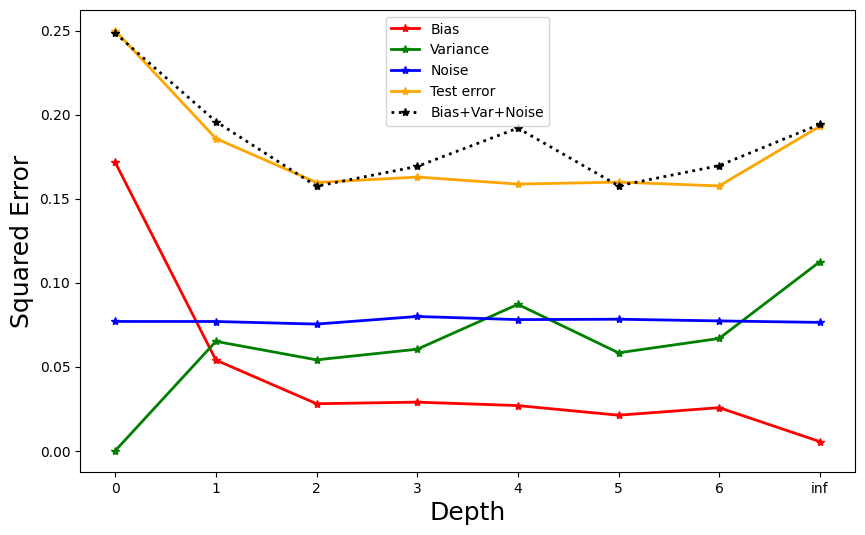

In [ ]:
# plot results
%matplotlib inline
plt.figure(figsize=(10,6))
plt.plot(lbias[:Ndepths], '*', c='r',linestyle='-',linewidth=2)
plt.plot(lvariance[:Ndepths], '*', c='g', linestyle='-',linewidth=2)
plt.plot(lnoise[:Ndepths], '*', c='b',linestyle='-',linewidth=2)
plt.plot(ltotal[:Ndepths], '*', c='orange', linestyle='-',linewidth=2)
plt.plot(lsum[:Ndepths], '*', c='k', linestyle='dotted',linewidth=2)

plt.legend(["Bias","Variance","Noise","Test error","Bias+Var+Noise"]);
plt.xlabel("Depth",fontsize=18);
plt.ylabel("Squared Error",fontsize=18);
plt.xticks([i for i in range(Ndepths)], depths);

In [ ]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import sys
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
from helper import *
%matplotlib notebook

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.10.12


In this project, we will work with an artificial 2D spiral dataset of size 150 (for visualization), and a high dimensional dataset ION (for a binary test classification problem).

In [ ]:
xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)
xTrIon, yTrIon, xTeIon, yTeIon = iondata()

NameError: ignored

In [ ]:
# Create a regression tree with no restriction on its depth
# and weights for each training example to be 1
# if you want to create a tree of max_depth k
# then call RegressionTree(depth=k)
tree = RegressionTree(depth=np.inf)

# To fit/train the regression tree
tree.fit(xTrSpiral, yTrSpiral)

# To use the trained regression tree to predict a score for the example
score = tree.predict(xTrSpiral)

# To use the trained regression tree to make a +1/-1 prediction
pred = np.sign(tree.predict(xTrSpiral))

tr_err   = np.mean((np.sign(tree.predict(xTrSpiral)) - yTrSpiral)**2)
te_err   = np.mean((np.sign(tree.predict(xTeSpiral)) - yTeSpiral)**2)

print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

NameError: ignored

In [ ]:
def visclassifier(fun,xTr,yTr):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)

    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T


    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)

    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly

    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
                   )

    plt.axis('tight')
    # shows figure and blocks
    plt.show()


tree=RegressionTree(depth=np.inf)
tree.fit(xTrSpiral,yTrSpiral) # compute tree on training data
visclassifier(lambda X: tree.predict(X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

# **Bagging in Action**
# Part One: Implement Bagging [Graded]
CART trees are known to be high variance classifiers if trained to full depth. Equivalently, CART trees of full depth easily overfit to the training set, which prevent the trees from performing well on new unseen data. An effective way to prevent overfitting is to use Bagging (short for b*ootstrap *aggregating). Implement the function forest, which builds a forest of m regression trees of depth=maxdepth. Each tree should be built using training data drawn by randomly sampling n examples from the training data with replacement, where n is the number of points in xTr.

We are going to keep it simple and not randomly subsample a small set of features to split on. Therefore, all trees will be constructed with a simple call to RegressionTree(depth=maxdepth). The function should output the list of trees.

Hint: You may find np.random.choice(a, b, replace=True) useful. It samples b numbers from [0, ..., a-1] with replacement.

In [ ]:
def forest(xTr, yTr, m, maxdepth=np.inf):
    """
    Creates a forest of m trees, each of depth=maxdepth.

    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of each tree

    Output:
        trees: list of decision trees of length m
    """

    n, d = xTr.shape
    trees = []

    for i in range(m):
        index = np.random.choice(n, n, replace=True)
        x_train, y_train = xTr[index], yTr[index]
        tree = RegressionTree(depth=maxdepth)
        tree.fit(x_train, y_train)
        trees.append(tree)

    return trees

In [ ]:
np.random.choice(xTe,7,replace=True)

ValueError: ignored

In [ ]:
index = np.random.choice(7,7,replace=True)
print(index)

[6 4 5 6 0 4 4]


In [ ]:
xTe = np.array([
        [0.45864, 0.71552],
        [2.44662, 1.68167],
        [1.00345, 0.15182],
        [-0.10560, -0.48155],
        [3.07264, 3.81535],
        [3.13035, 2.72151],
        [2.25265, 3.78697]])

yTe = np.array([1, 2, 1, 1, 2, 2, 2])

In [ ]:
xTe[index]

array([[2.25265, 3.78697],
       [3.07264, 3.81535],
       [3.13035, 2.72151],
       [2.25265, 3.78697],
       [0.45864, 0.71552],
       [3.07264, 3.81535],
       [3.07264, 3.81535]])

In [ ]:
def forest_test1():
    m = 20
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees = forest(x, y, m)
    return len(trees) == m # make sure there are m trees in the forest

def forest_test2():
    m = 20
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    max_depth = 4
    trees = forest(x, y, m, max_depth)
    depths_forest = np.array([tree.depth for tree in trees]) # Get the depth of all trees in the forest
    return np.all(depths_forest == max_depth) # make sure that the max depth of all the trees is correct


def forest_test3():
    s = set()

    def DFScollect(tree):
        # Do Depth first search to all prediction in the tree
        if tree.left is None and tree.right is None:
            s.add(tree.prediction)
        else:
            DFScollect(tree.right)
            DFScollect(tree.left)

    m = 200
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees = forest(x, y, m);

    lens = np.zeros(m)

    for i in range(m):
        s.clear()
        DFScollect(trees[i].root)
        lens[i] = len(s)

    # Check that about 63% of data is represented in each random sample
    return abs(np.mean(lens) - 100 * (1 - 1 / np.exp(1))) < 2

runtest(forest_test1, 'forest_test1')
runtest(forest_test2, 'forest_test2')
runtest(forest_test3, 'forest_test3')

# Part Two: Implement evalforest [Graded]
Now implement the function evalforest, which should take as input a set of  𝑚
  trees and a set of  𝑛
  test inputs and return the average prediction of all the trees.

Note that for bagging, we take the average over all trees weighted equally. In a later project, you will implement a different version of this function that assigns different weights to predictions of different trees.

In [ ]:
def evalforest(trees, X):
    """
    Evaluates X using trees.

    Input:
        trees:  list of length m of RegressionTree decision trees
        X:      n x d matrix of data points

    Output:
        pred:   n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape

    pred = np.zeros(n)
    p = np.zeros((n,m))

    for m in trees: #should be tree rather than m, m is defined as a dimension
        p[:,m] = tree.predict(X) #p is an n-dimensional vector of predictions for each tree

    return np.mean(p, axis = 1) #averages are taken across m, to give an n-dimensional vector with averages

In [ ]:
#correct implementation
def evalforest(trees, X):
    """
    Evaluates X using trees.

    Input:
        trees:  list of length m of RegressionTree decision trees
        X:      n x d matrix of data points

    Output:
        pred:   n-dimensional vector of predictions
    """
    m = len(trees)
    n, d = X.shape

    pred = np.zeros(n)

    for tree in trees:
        p = tree.predict(X) # p is an n-dimensional vector of predictions for each tree
        pred = np.column_stack((pred, p)) # pred is an n x m dimensional array

    return np.mean(pred[:, 1:], axis=1) # averages are taken across m, to give an n-dimensional vector with averages, it starts with 1: so that it skips the initial zero vector


In [ ]:
#correct implementtation
def evalforest(trees, X):
    """
    Evaluates X using trees.

    Input:
        trees:  list of length m of RegressionTree decision trees
        X:      n x d matrix of data points

    Output:
        pred:   n-dimensional vector of predictions
    """
    m = len(trees)
    n, d = X.shape

    pred = np.zeros((n, m))

    for i, tree in enumerate(trees):
        pred[:, i] = tree.predict(X) # Store the predictions for each tree in the corresponding column of pred

    return np.mean(pred, axis=1) # Compute the average predictions across the trees



Visualize the Decision Boundary
The following script visualizes the decision boundary of an ensemble of decision tree. You might observe that the decision boundary is less rigid with an ensemble of 50 trees than with just 1 CART tree. This is to be expected as a forest is just an ensemble of CART trees and averages the predictions. Consequently, the test error should also be less with the the ensemble than with just 1 CART tree.

In [ ]:
trees=forest(xTrSpiral,yTrSpiral, 50) # compute tree on training data
visclassifier(lambda X:evalforest(trees,X),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTeSpiral)) != yTeSpiral))

Evaluate Test and Training Error
The following script evaluates the test and training error of an ensemble of decision trees as we vary the number of trees.

In [ ]:
M=20 # max number of trees
err_trB=[]
err_teB=[]
alltrees=forest(xTrIon,yTrIon,M)
for i in range(M):
    trees=alltrees[:i+1]
    trErr = np.mean(np.sign(evalforest(trees,xTrIon)) != yTrIon)
    teErr = np.mean(np.sign(evalforest(trees,xTeIon)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M), err_trB, '-*', label="Training error")
line_te, = plt.plot(range(M), err_teB, '-*', label="Testing error")
plt.title("Ensemble of Decision Trees")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

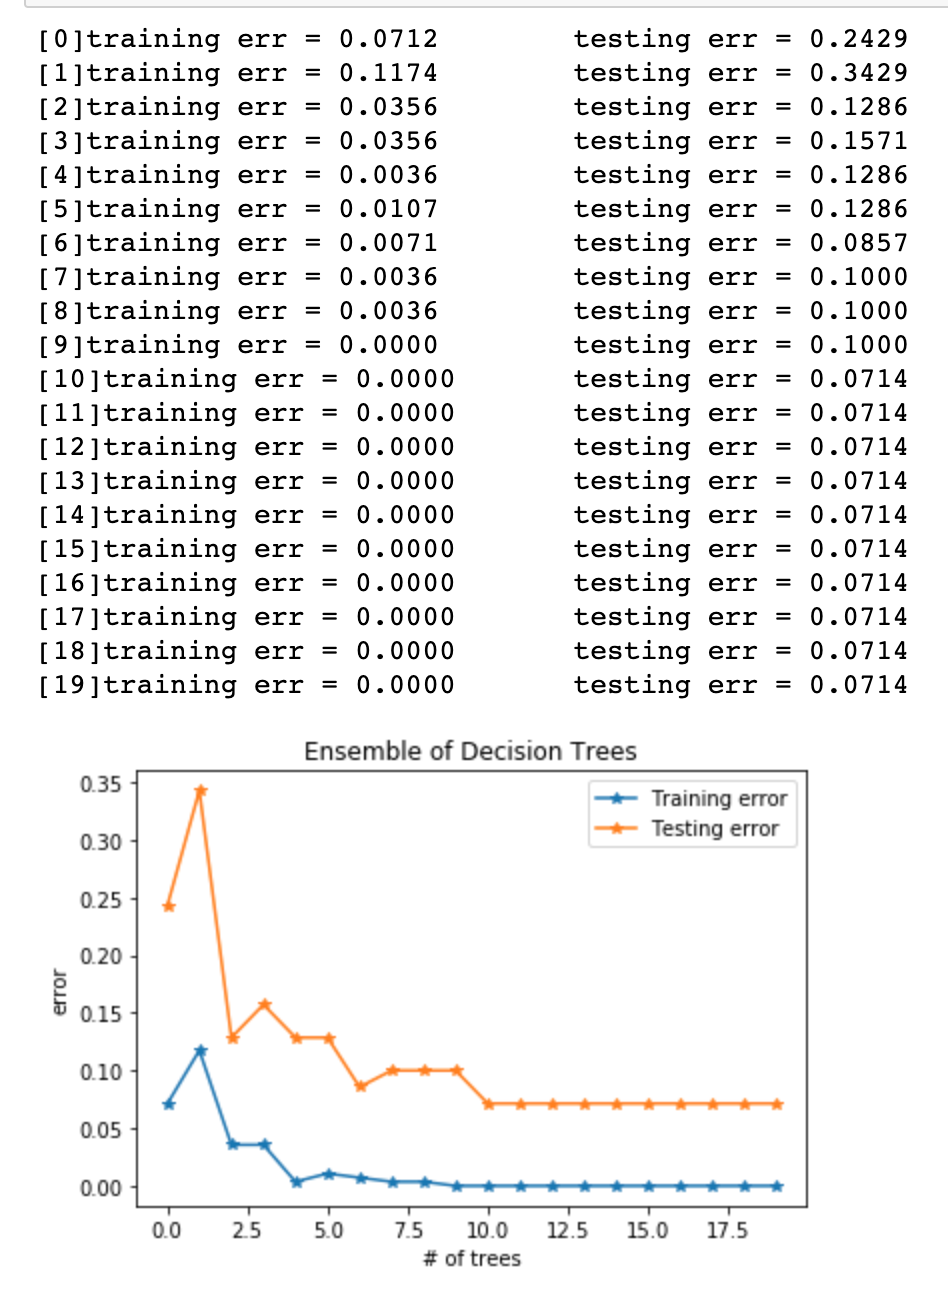

1D Interactive Demo
The next interactive demo shows a 1-dimensional curve fitted with ensembles of decision trees. We sample 100 training data points from the curve with additive noise. Note how the predicted curve becomes increasingly smooth as you add trees — adding trees should thus decrease training and testing error. The testing error may be a little higher than the training error, but there is no large gap as ensembles are quite good at avoiding overfitting.

In [ ]:
def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,Q,trees

    if event.key == 'shift': Q+=10
    else: Q+=1
    Q=min(Q,M)


    plt.cla()
    plt.xlim((0,1))
    plt.ylim((0,1))
    pTest=evalforest(trees[:Q],xTest);
    pTrain=evalforest(trees[:Q],xTrain);


    errTrain=np.sqrt(np.mean((pTrain-yTrain)**2))
    errTest=np.sqrt(np.mean((pTest-yTest)**2))

    plt.plot(xTrain[:,0],yTrain,'bx')
    plt.plot(xTest[:,0],pTest,'r-')
    plt.plot(xTest[:,0],yTest,'k-')

    plt.legend(['Training data','Prediction'])
    plt.title('(%i Trees)  Error Tr: %2.4f, Te:%2.4f' % (Q,errTrain,errTest))
    plt.show()


n=100; # number of training points
NOISE=0.05 # magnitude of noise
xTrain=np.array([np.linspace(0,1,n),np.zeros(n)]).T
yTrain=2*np.sin(xTrain[:,0]*3)*(xTrain[:,0]**2)
yTrain+=np.random.randn(yTrain.size)*NOISE;
ntest=300; # density of test points
xTest=np.array([linspace(0,1,ntest),np.zeros(ntest)]).T
yTest=2*np.sin(xTest[:,0]*3)*(xTest[:,0]**2)



# Hyper-parameters (feel free to play with them)
M=100 # number of trees
depth=np.inf
trees=forest(xTrain, yTrain, M,maxdepth=depth)
Q=0;

%matplotlib notebook
fig = plt.figure()
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Click to add a tree (shift-click and add 10 trees).');
plt.title('Click to start boosting on this 1D data (Shift-click to add 10 trees).')
plt.plot(xTrain[:,0],yTrain,'*')
plt.plot(xTest[:,0],yTest,'k-')
plt.xlim(0,1)
plt.ylim(0,1)

<IPython.core.display.Javascript object>

Click to add a tree (shift-click and add 10 trees).


(0.0, 1.0)

2D Interactive Demo
The following demo visualizes the bagged classifier. Add your own points directly on the graph with click and shift+click to see the prediction boundaries. There will be a delay between clicks as the new classifier is trained.

In [ ]:
def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,w,b,M
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]])
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)

    w = np.array(w).flatten()

    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get forest
    trees=forest(xTrain,yTrain,M)
    fun = lambda X:evalforest(trees,X)
    # test all of these points on the grid
    testpreds = fun(xTe)

    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly

    plt.cla()
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()


xTrain= np.array([[5,6]])
b=yTrIon
yTrain = np.array([1])
w=xTrIon
M=20

%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Note: You may notice a delay when adding points to the visualization.')
plt.title('Use shift-click to add negative points.')

NameError: ignored

In [ ]:
import numpy as np
from pylab import *
from numpy.matlib import repmat
import sys
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import loadmat
import time
from helper import *
%matplotlib inline

print('You\'re running python %s' % sys.version.split(' ')[0])

You're running python 3.10.12


In [ ]:
xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)
xTrIon, yTrIon, xTeIon, yTeIon = iondata()

In [ ]:
#Create a regression tree with depth 4
tree = RegressionTree(depth=4)

# To fit/train the regression tree
tree.fit(xTrSpiral, yTrSpiral)

# To use the trained regression tree to predict a score for the example
score = tree.predict(xTrSpiral)

# To use the trained regression tree to make a +1/-1 prediction
pred = np.sign(tree.predict(xTrSpiral))

Now run the following cell that evaluates your depth=4 decision tree on the training set and test set. You might see that the difference between training error and test error is small (no overfitting) but both the errors are rather high. This is a sign of underfitting or high bias.

In [ ]:
# Evaluate the depth 4 decision tree
# tr_err   = np.mean((np.sign(tree.predict(xTrSpiral)) - yTrSpiral)**2)
# te_err   = np.mean((np.sign(tree.predict(xTeSpiral)) - yTeSpiral)**2)

print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

Training error: 0.3000
Testing error:  0.3533

To convince you further that the depth=4 tree is underfitting, we create the following function visclassifier(), which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the spiral data set.

In [ ]:
def visclassifier(fun,xTr,yTr,newfig=True):
    """
    visualize decision boundary
    Define the symbols and colors we'll use in the plots later
    """

    yTr = np.array(yTr).flatten()

    symbols = ["ko","kx"]
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    # get the unique values from labels array
    classvals = np.unique(yTr)

    if newfig:
        plt.figure()

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(min(xTr[:, 0]), max(xTr[:, 0]),res)
    yrange = np.linspace(min(xTr[:, 1]), max(xTr[:, 1]),res)

    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T


    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # test all of these points on the grid
    testpreds = fun(xTe)

    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly

    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(xTr[yTr == c,0],
            xTr[yTr == c,1],
            marker=marker_symbols[idx],
            color='k'
                   )

    plt.axis('tight')
    # shows figure and blocks
    plt.show()


visclassifier(lambda X: tree.predict(X),xTrSpiral,yTrSpiral)

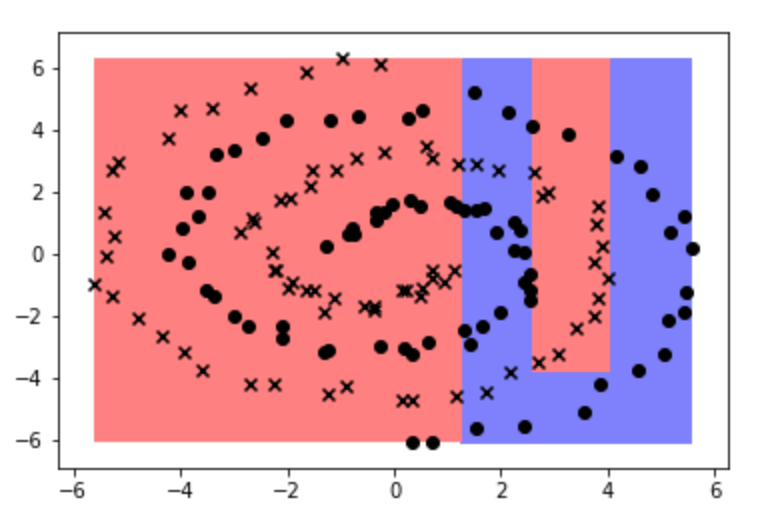

As you can see from the graph above, the depth=4 tree is too simple and is not capable to capture the inherit information of the dataset.

# Gradient Boosting Regression Tree in Action
## **Part One: Implement evalboostforest [Graded]**
CART trees are known to be high variance classifiers if trained to full depth. However, if you build trees of small depth (e.g. only depth=3 or depth=4), the trees do not overfit as we see above. Instead, they suffer from high bias and thus underfit. We can reduce the bias of a classifier with gradient boosting.

Before implementing Gradient Boosted Regression Trees, you will implement evalboostforest with an additional argument alphas that lets you weigh the trees' predictions with any weights (in bagging all weights alpha[i] were equal).

Similar to bagging, the evalboostforest is provided a list of  𝑚
  trees  [ℎ1,…,ℎ𝑚]
  and  𝑛
   𝑑
 -dimensional data points. However, this time, the function will weigh each tree  ℎ𝑗
  according to  𝛼𝑗
 .

More precisely, for each test sample  𝐱𝑖
 , evalboostforest should output the following prediction:

𝐻(𝐱𝑖)=∑𝑗=1𝑚𝛼𝑗ℎ𝑗(𝐱𝑖)

In [ ]:
def evalboostforest(trees, X, alphas=None):
    """
    Evaluates data points X using trees using weights alphas (optional).

    Input:
        trees:  list of length m of RegressionTree decision trees
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector for the ensemble's prediction

    Output:
        pred:   n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape
    n,m = c.shape

    if alphas is None:
        alphas = np.ones(m) / len(trees)

    pred = np.zeros(n)

    for i, tree in enumerate(trees):
      c[:,i] = trees[i].fit(X) #nxm array
      return c

    c = np.multiply(alphas, c, axis = 1) #scalar multiplication of m vector by mxn array, across m columns
    pred = np.sum(c, axis=1) #sum of weighted predictions across m column trees

    return pred

In [ ]:
#correct implementation
def evalboostforest(trees, X, alphas=None):
    """
    Evaluates data points X using trees using weights alphas (optional).

    Input:
        trees:  list of length m of RegressionTree decision trees
        X:      n x d matrix of data points
        alphas: m-dimensional weight vector for the ensemble's prediction

    Output:
        pred:   n-dimensional vector of predictions
    """
    m = len(trees)
    n, d = X.shape

    if alphas is None:
        alphas = np.ones(m) / m

    pred = np.zeros(n)

    for i, tree in enumerate(trees):
        pred += alphas[i] * tree.predict(X) #alphas m-dimensional vector, each alpha corresponding to ith tree is broadcast scalar multiplied to each prediction in n-dimensional vector tree.predict(X)

    return pred


In [ ]:
def evalboostforest_test0():
    m = 200
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees = forest(x, y, m) # create a list of trees
    preds = evalboostforest(trees, x)
    return preds.shape == y.shape

def evalboostforest_test1():
    m = 200
    x = np.random.rand(10,3)
    y = np.ones(10)
    x2 = np.random.rand(10,3)

    max_depth = 0

    # Create a forest with trees depth 0
    # Since the data are all ones, each tree will return 1 as prediction
    trees = forest(x, y, m, max_depth) # create a list of trees
    pred = evalboostforest(trees, x2)[0]
    return np.isclose(pred,1)  # the prediction should be equal to the sum of weights

def evalboostforest_test2():
    # results should match evalforest if alphas are 1/m and labels +1, -1
    m = 20
    x = np.arange(100).reshape((100, 1))
    y = np.sign(np.arange(100))
    trees = forest(x, y, m) # create a list of m trees

    alphas=np.ones(m)/m
    preds1 = evalforest(trees, x) #evaluate the forest using our own implementation
    preds2 = evalboostforest(trees, x, alphas)
    return np.all(np.isclose(preds1,preds2))

def evalboostforest_test3():
    # if only alpha[i]=1 and all others are 0, the result should match exactly
    # the predictions of the ith tree
    m = 20
    x = np.random.rand(100,5)
    y = np.arange(100)
    x2 = np.random.rand(20,5)

    trees = forest(x, y, m)  # create a list of m trees
    allmatch=True
    for i in range(m): # go through each tree i
        alphas=np.zeros(m)
        alphas[i]=1.0; # set only alpha[i]=1 all other alpha=0
        preds1 = trees[i].predict(x2) # get prediction of ith tree
        preds2 = evalboostforest(trees, x2, alphas) # get prediction of weighted ensemble
        allmatch=allmatch and all(np.isclose(preds1,preds2))
    return allmatch


# and some new tests to check if the weights (and the np.sign function) were incorporated correctly
runtest(evalboostforest_test0, 'evalboostforest_test0')
runtest(evalboostforest_test1, 'evalboostforest_test1')
runtest(evalboostforest_test2, 'evalboostforest_test2')
runtest(evalboostforest_test3, 'evalboostforest_test3')

# **Part Two: Implement GBRT [Graded]**
Finally implement the function GBRT, which applies Gradient Boosting to the decision tree model. You can use the following pseudocode to write the function. You can also use your evalboostforest function to evaluate your boosted ensemble (provided you pass on the weights correctly).




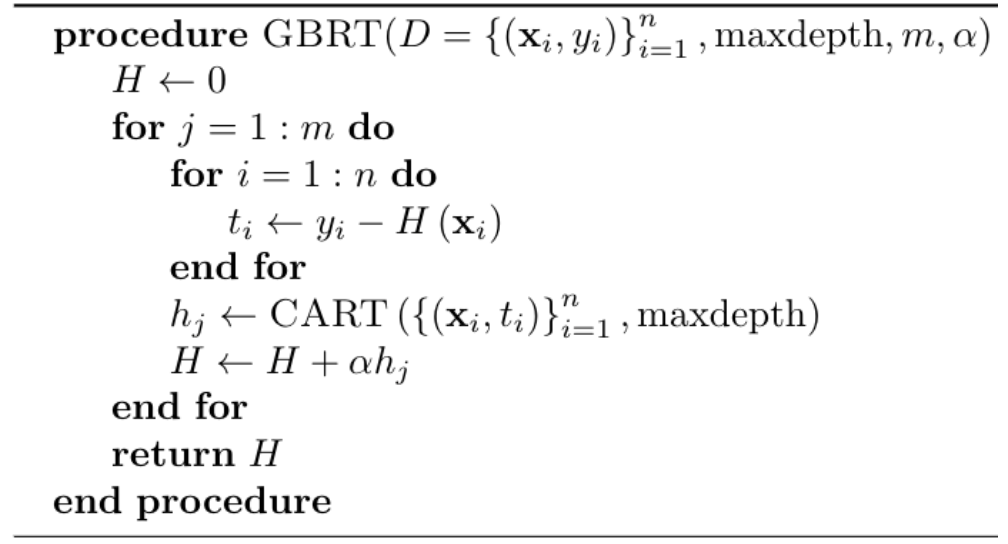

In [ ]:
def GBRT(xTr, yTr, m, maxdepth=4, alpha=0.1):
    """
    An implementation of Gradient Boosted Regression Trees with m trees of depth=maxdepth.

    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of tree
        alpha:    learning rate for the GBRT (also the weight for each tree in the ensemble)


    Output:
        trees, alphas
        trees: list of decision trees of length m
        alphas: weights of each tree
    """

    n, d = xTr.shape
    trees = []
    alphas = []

    # Ensemble tree H = 0 right now. Therefore, t_i = y_i for all i
    H = 0
    # Make a copy of the ground truth label
    # this will be the initial ground truth for the first GBRT
    t = np.copy(yTr)
    #Initialize t as a copy of yTr
    for i in range(m): #For each iteration:
        tree = RegressionTree(depth=maxdepth)
        trees += tree.fit(xTr, t)#Create a tree, fit to xTr and t #Append this tree to list of trees
        alphas += alpha #Append alpha to list of alphas
        predH = evalboostforest(trees, xTr, alphas=alphas) #Generate sum of weighted predictions of all trees with given alphas
        t = np.subtract(t, predH, axis=0) #Calculate new t value by subtracting weighted predictions from yTr
    return trees, alphas #Return list of trees and list of alphas

In [ ]:
#correct implementation
def GBRT(xTr, yTr, m, maxdepth=4, alpha=0.1):
    """
    An implementation of Gradient Boosted Regression Trees with m trees of depth=maxdepth.

    Input:
        xTr:      n x d matrix of data points
        yTr:      n-dimensional vector of labels
        m:        number of trees in the forest
        maxdepth: maximum depth of tree
        alpha:    learning rate for the GBRT (also the weight for each tree in the ensemble)

    Output:
        trees, alphas
        trees: list of decision trees of length m
        alphas: weights of each tree
    """
    n, d = xTr.shape
    trees = []
    alphas = []

    # Initialize t as a copy of yTr
    t = np.copy(yTr)

    for i in range(m):
        tree = RegressionTree(depth=maxdepth)
        tree.fit(xTr, t)
        trees.append(tree)
        alphas.append(alpha)
        predH = evalboostforest(trees, xTr, alphas=alphas)
        t = np.subtract(yTr, predH)

    return trees, alphas


In [ ]:
def GBRT_test1():
    m = 40
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    trees, weights = GBRT(x, y, m, alpha=0.1)
    return len(trees) == m and len(weights) == m # make sure there are m trees in the forest

def GBRT_test2():
    m = 20
    x = np.arange(100).reshape((100, 1))
    y = np.arange(100)
    max_depth = 4
    trees, weights = GBRT(x, y, m, max_depth)
    depths_forest = np.array([tree.depth for tree in trees]) # Get the depth of all trees in the forest
    return np.all(depths_forest == max_depth) # make sure that the max depth of all the trees is correct

def GBRT_test3():
    m = 4
    xTrSpiral,yTrSpiral,_,_= spiraldata(150)
    max_depth = 4
    trees, weights = GBRT(xTrSpiral, yTrSpiral, m, max_depth, 1) # Create a gradient boosted forest with 4 trees

    errs = []
    for i in range(m):
        predH = evalboostforest(trees[:i+1], xTrSpiral, weights[:i+1]) # calculate the prediction of the first i-th tree
        err = np.mean(np.sign(predH) != yTrSpiral) # calculate the error of the first i-th tree
        errs.append(err) # keep track of the error

    # your errs should be decreasing, i.e., the different between two subsequent errors is <= 0
    return np.all(np.diff(errs) <= 0)

runtest(GBRT_test1, 'GBRT_test1')
runtest(GBRT_test2, 'GBRT_test2')
runtest(GBRT_test3, 'GBRT_test3')

## **Visualize the Decision Boundary**
The following script visualizes the decision boundary of a boosted ensemble of CART trees. It should perform much better than just 1 CART tree of the same depth.

In [ ]:
trees, weights=GBRT(xTrSpiral,yTrSpiral, 40, maxdepth=4, alpha=0.03) # compute tree on training data
visclassifier(lambda X:evalboostforest(trees, X, weights),xTrSpiral,yTrSpiral)
print("Training error: %.4f" % np.mean(np.sign(evalforest(trees,xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees,xTeSpiral)) != yTeSpiral))

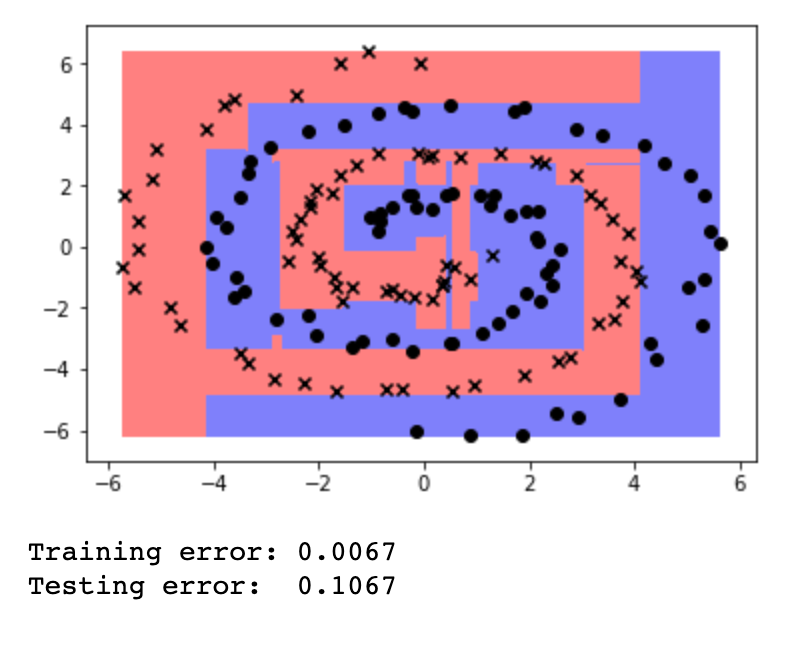

# **Evaluate Test and Training Error**
The following script evaluates the test and training error of an ensemble of CART trees as we vary the number of trees.

In [ ]:
M=40 # max number of trees
err_trB=[]
err_teB=[]
alltrees, allweights =GBRT(xTrIon,yTrIon, M, maxdepth=4, alpha=0.05)
for i in range(M):
    trees=alltrees[:i+1]
    weights=allweights[:i+1]
    trErr = np.mean(np.sign(evalboostforest(trees,xTrIon, weights)) != yTrIon)
    teErr = np.mean(np.sign(evalboostforest(trees,xTeIon, weights)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i,trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M), err_trB, '-*', label="Training error")
line_te, = plt.plot(range(M), err_teB, '-*', label="Testing error")
plt.title("Gradient Boosted Trees")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()

0]training err = 0.0356	testing err = 0.2286
[1]training err = 0.0320	testing err = 0.2286
[2]training err = 0.0214	testing err = 0.1571
[3]training err = 0.0249	testing err = 0.2286
[4]training err = 0.0178	testing err = 0.1571
[5]training err = 0.0178	testing err = 0.1571
[6]training err = 0.0142	testing err = 0.1571
[7]training err = 0.0142	testing err = 0.1571
[8]training err = 0.0107	testing err = 0.1571
[9]training err = 0.0071	testing err = 0.1571
[10]training err = 0.0107	testing err = 0.1571
[11]training err = 0.0071	testing err = 0.1571
[12]training err = 0.0071	testing err = 0.1714
[13]training err = 0.0071	testing err = 0.1571
[14]training err = 0.0071	testing err = 0.1714
[15]training err = 0.0071	testing err = 0.1571
[16]training err = 0.0071	testing err = 0.1571
[17]training err = 0.0071	testing err = 0.1571
[18]training err = 0.0071	testing err = 0.1714
[19]training err = 0.0036	testing err = 0.1429
[20]training err = 0.0036	testing err = 0.1571
[21]training err = 0.0036	testing err = 0.1429
[22]training err = 0.0036	testing err = 0.1429
[23]training err = 0.0036	testing err = 0.1429
[24]training err = 0.0036	testing err = 0.1429
[25]training err = 0.0036	testing err = 0.1429
[26]training err = 0.0036	testing err = 0.1429
[27]training err = 0.0036	testing err = 0.1429
[28]training err = 0.0036	testing err = 0.1429
[29]training err = 0.0036	testing err = 0.1286
[30]training err = 0.0036	testing err = 0.1286
[31]training err = 0.0036	testing err = 0.1143
[32]training err = 0.0036	testing err = 0.1000
[33]training err = 0.0036	testing err = 0.1000
[34]training err = 0.0036	testing err = 0.1000
[35]training err = 0.0036	testing err = 0.1000
[36]training err = 0.0036	testing err = 0.0857
[37]training err = 0.0036	testing err = 0.0857
[38]training err = 0.0036	testing err = 0.0857
[39]training err = 0.0036	testing err = 0.0857

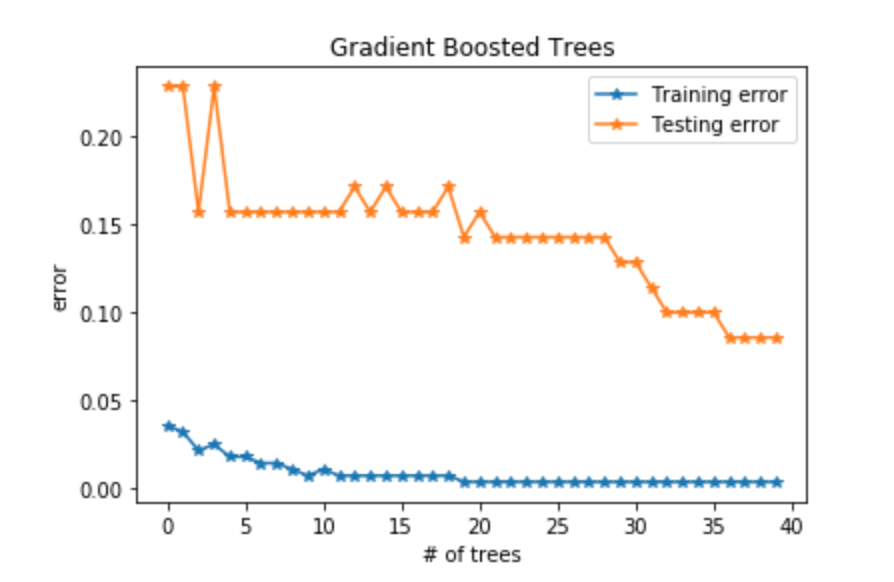

# **2D Interactive Demo on Spiral Data (adding trees with clicks)**
The following demo visualizes the GBRT classifier on the spiral data. With each click you can add one more regression tree to the classifier.

In [ ]:
def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,w,b,M,Q,trees,weights

    if event.key == 'shift': Q+=10
    else: Q+=1
    Q=min(Q,M)

    classvals = np.unique(yTrain)

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get forest

    fun = lambda X:evalboostforest(trees[:Q],X, weights[:Q])
    # test all of these points on the grid
    testpreds = fun(xTe)
    trerr=np.mean(np.sign(fun(xTrain))==np.sign(yTrain))

    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)

    plt.cla()
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],xTrain[yTrain == c,1],marker=marker_symbols[idx],color='k')
    plt.show()
    plt.title('# Trees: %i Training Accuracy: %2.2f' % (Q,trerr))


xTrain=xTrSpiral.copy()/14+0.5
yTrain=yTrSpiral.copy()
yTrain=yTrain.astype(int)

# Hyper-parameters (feel free to play with them)
M=50
alpha=0.05;
depth=5;
trees, weights=GBRT(xTrain, yTrain, M,alpha=alpha,maxdepth=depth)
Q=0;


%matplotlib notebook
fig = plt.figure()
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Click to add a tree.');
plt.title('Click to start boosting on the spiral data.')
visclassifier(lambda X: np.sum(X,1)*0,xTrain,yTrain,newfig=False)
plt.xlim(0,1)
plt.ylim(0,1)

# **1D Interactive Demo**
The next interactive demo shows a 1-dimensional curve fitted with GBRT. We sample 100 training data points from the curve with additive noise. Note how the training and testing errors decrease as you add trees to your ensemble, but the testing error eventually increases again. Initially (with only a few trees) you will see that the predicted (red) curve is very smooth and then becomes increasingly less smooth as you add more trees (here you are decreasing bias).

In the end, the predicted curve becomes rather complicated and overfits to the training data (high variance). In this demo, you can nicely see how GBRT starts out with high bias (too smooth), then lowers the bias, but eventually ends up with high variance (very jiggery overfitting curve). As with hyperparameters in Machine Learning, the number of trees in GBRT has a significant impact on the generalization error.

In [ ]:
def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,Q,trees,weights

    if event.key == 'shift': Q+=10
    else: Q+=1
    Q=min(Q,M)


    plt.cla()
    plt.xlim((0,1))
    plt.ylim((0,1))
    pTest=evalboostforest(trees[:Q],xTest,weights[:Q])
    pTrain=evalboostforest(trees[:Q],xTrain,weights[:Q])


    errTrain=np.sqrt(np.mean((pTrain-yTrain)**2))
    errTest=np.sqrt(np.mean((pTest-yTest)**2))

    plt.plot(xTrain[:,0],yTrain,'bx')
    plt.plot(xTest[:,0],pTest,'r-')
    plt.plot(xTest[:,0],yTest,'k-')

    plt.legend(['Training data','Prediction'])
    plt.title('(%i Trees)  Error Tr: %2.4f, Te:%2.4f' % (Q,errTrain,errTest))
    plt.show()


n=100;
NOISE=0.05
xTrain=np.array([np.linspace(0,1,n),np.zeros(n)]).T
yTrain=2*np.sin(xTrain[:,0]*3)*(xTrain[:,0]**2)
yTrain+=np.random.randn(yTrain.size)*NOISE;
ntest=300;
xTest=np.array([linspace(0,1,ntest),np.zeros(ntest)]).T
yTest=2*np.sin(xTest[:,0]*3)*(xTest[:,0]**2)




# Hyper-parameters (feel free to play with them)
M=400
alpha=0.05;
depth=3;
trees, weights=GBRT(xTrain, yTrain, M,alpha=alpha,maxdepth=depth)
Q=0;

%matplotlib notebook
fig = plt.figure()
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Click to add a tree (shift-click and add 10 trees).');
plt.title('Click to start boosting on this 1D data (Shift-click to add 10 trees).')
plt.plot(xTrain[:,0],yTrain,'*')
plt.plot(xTest[:,0],yTest,'k-')
plt.xlim(0,1)
plt.ylim(0,1)

2D Interactive Demo
The following demo visualizes the GBRT classifier. Add your own points directly on the graph with click and shift+click to see the prediction boundaries. There will be a delay between clicks as the new classifier is trained.

In [ ]:
def onclick_forest(event):
    """
    Visualize forest, including new point
    """
    global xTrain,yTrain,w,b,M
    # create position vector for new point
    pos=np.array([[event.xdata,event.ydata]])
    if event.key == 'shift': # add positive point
        color='or'
        label=1
    else: # add negative point
        color='ob'
        label=-1
    xTrain = np.concatenate((xTrain,pos), axis = 0)
    yTrain = np.append(yTrain, label)
    marker_symbols = ['o', 'x']
    classvals = np.unique(yTrain)

    w = np.array(w).flatten()

    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]

    # return 300 evenly spaced numbers over this interval
    res=300
    xrange = np.linspace(0, 1,res)
    yrange = np.linspace(0, 1,res)

    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T

    xTe = np.array([pixelX.flatten(), pixelY.flatten()]).T

    # get forest
    trees, weights=GBRT(xTrain, yTrain, M)
    fun = lambda X:evalboostforest(trees,X, weights)
    # test all of these points on the grid
    testpreds = fun(xTe)

    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly

    plt.cla()
    plt.xlim((0,1))
    plt.ylim((0,1))
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)

    for idx, c in enumerate(classvals):
        plt.scatter(xTrain[yTrain == c,0],
            xTrain[yTrain == c,1],
            marker=marker_symbols[idx],
            color='k'
            )
    plt.show()


xTrain= np.array([[5,6]])
b=yTrIon
yTrain = np.array([1])
w=xTrIon
M=5

%matplotlib notebook
fig = plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick_forest)
print('Note: You may notice a delay when adding points to the visualization.')
plt.title('Use shift-click to add negative points.')